In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#names = ['Size', '#Threads', 'Runtime (s)', 'Energy (J)']
#df = pd.read_csv('matmul_cn128.csv', names=names, usecols=[0, 1, 3, 5])

names = ['Size', '#Threads', 'Runtime (s)', 'Energy (J)']
df = pd.read_csv('data/matmul_cn128_rust.csv', names=names, usecols=[0, 1, 2, 4])

flop = df['Size'] * df['Size'] * (2 * df['Size'] - 1)
df['GFLOP/s'] = flop / df['Runtime (s)'] / 1e9
df['GFLOP/J'] = flop / df['Energy (J)'] / 1e9

df

,Size,#Threads,Runtime (s),Energy (J),GFLOP/s,GFLOP/J
0,300,1,0.093216,1.472573,0.578336,0.036609
1,300,2,0.046823,0.899543,1.151352,0.059930
2,300,3,0.034095,0.744700,1.581192,0.072392
3,300,4,0.023874,0.619453,2.258145,0.087028
4,300,5,0.019732,0.565483,2.732103,0.095334
...,...,...,...,...,...,...
203,1500,12,1.820015,75.170599,3.707525,0.089766
204,1500,13,1.908935,77.982271,3.534824,0.086529
205,1500,14,1.959254,79.800360,3.444041,0.084558
206,1500,15,2.068293,83.856777,3.262472,0.080468


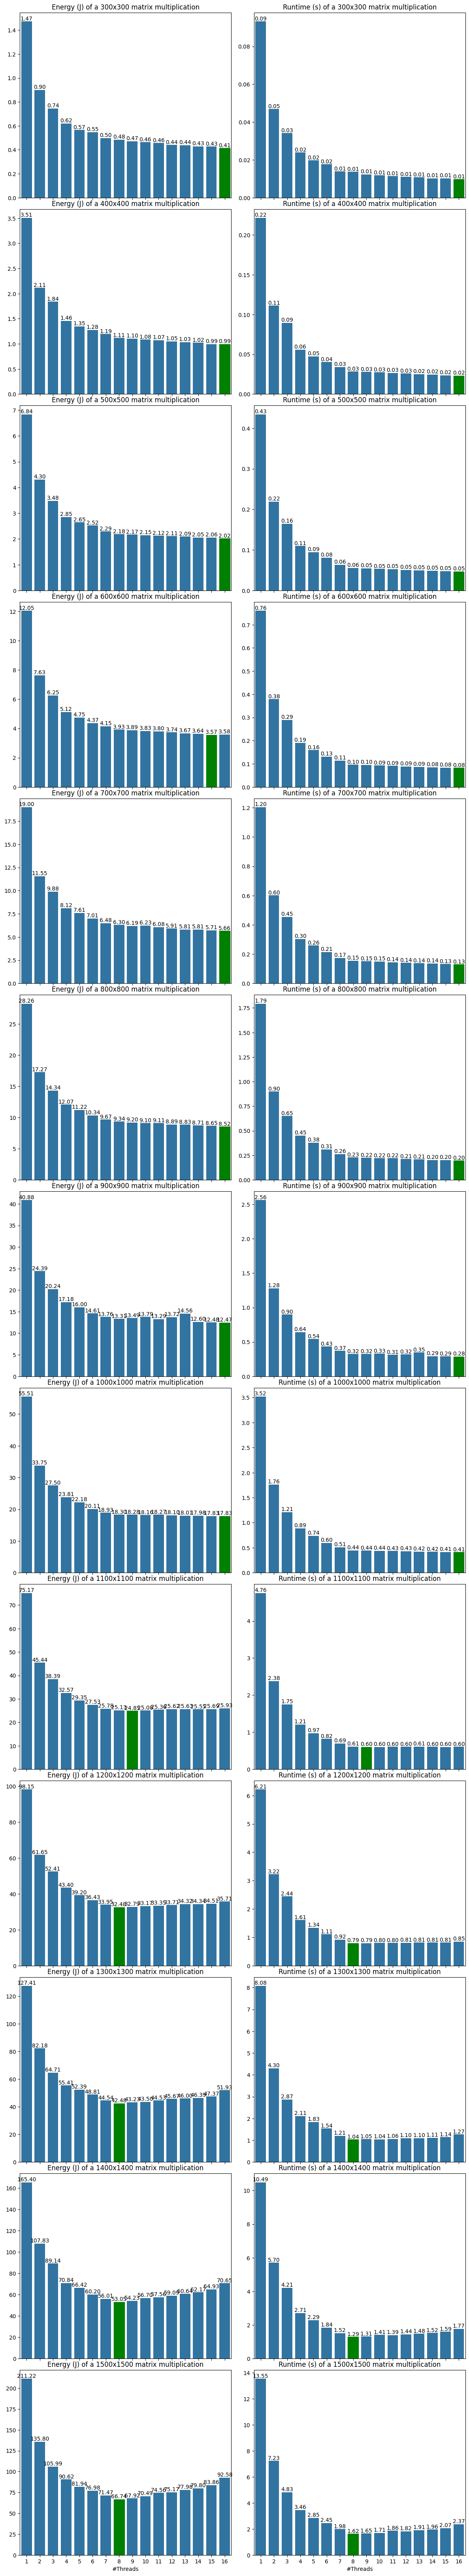

In [5]:
by_size = df.groupby('Size')

fig, axs = plt.subplots(len(by_size), 2, figsize=(12, 5 * len(by_size)), sharex=True)
fig.tight_layout()

for ((size, dfx), (ax_j, ax_s)) in zip(df.groupby('Size'), axs):
    sns.barplot(dfx, x='#Threads', y='Energy (J)', ax=ax_j)
    sns.barplot(dfx, x='#Threads', y='Runtime (s)', ax=ax_s)

    ax_j.set_title(f'Energy (J) of a {size}x{size} matrix multiplication')
    ax_s.set_title(f'Runtime (s) of a {size}x{size} matrix multiplication')
    ax_j.set_ylabel('')
    ax_s.set_ylabel('')
    
    def color_best(ax, col):
        ax.bar_label(ax.containers[0], fmt='%.2f')
        for bar in ax.patches:
            if bar.get_height() == dfx[col].min():
                bar.set_color('g')
                return
    color_best(ax_j, 'Energy (J)')
    color_best(ax_s, 'Runtime (s)')

plt.show()

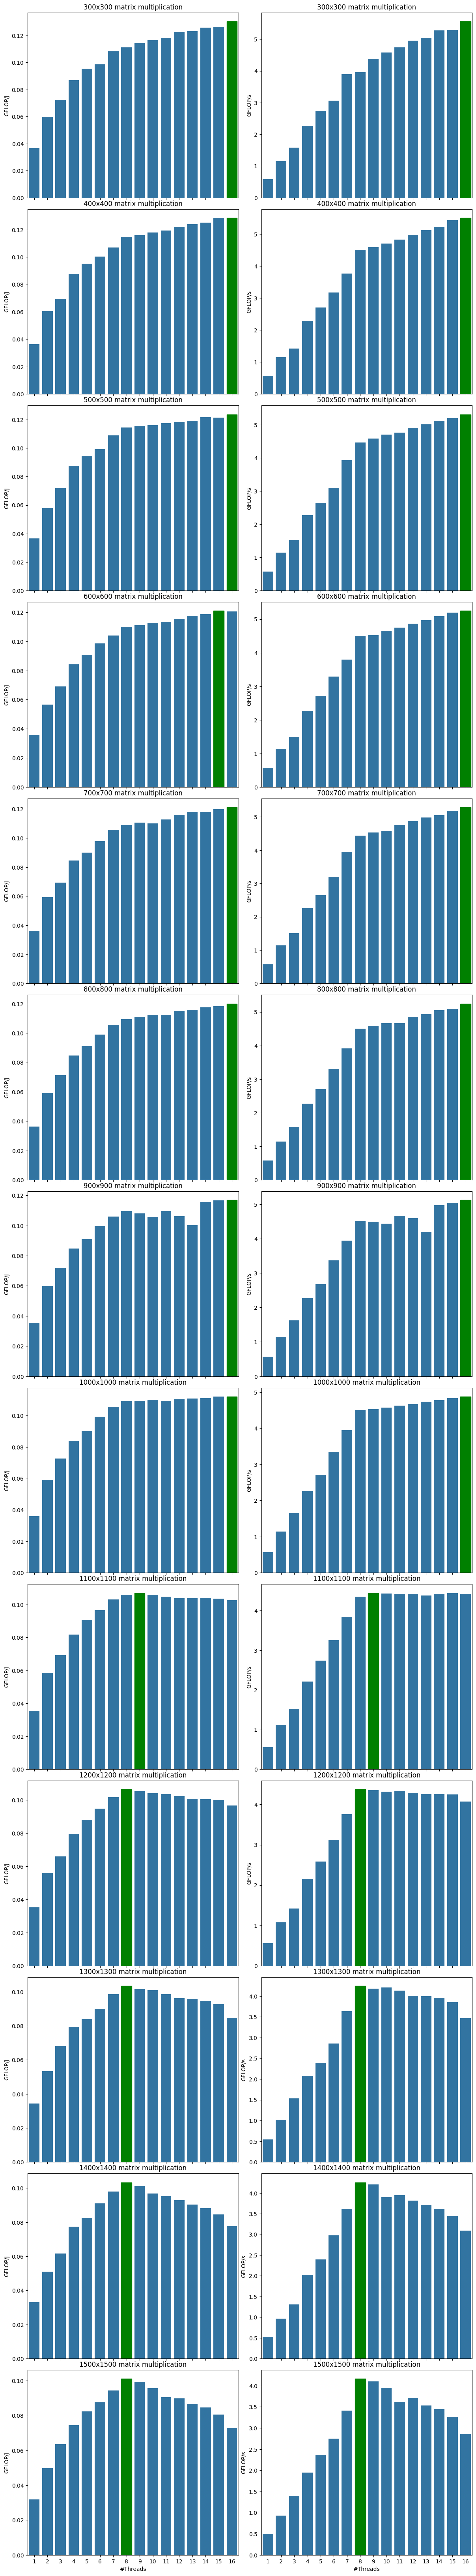

In [6]:
by_size = df.groupby('Size')

fig, axs = plt.subplots(len(by_size), 2, figsize=(12, 5 * len(by_size)), sharex=True)
fig.tight_layout()

for ((size, dfx), (ax_j, ax_s)) in zip(df.groupby('Size'), axs):
    sns.barplot(dfx, x='#Threads', y='GFLOP/J', ax=ax_j)
    sns.barplot(dfx, x='#Threads', y='GFLOP/s', ax=ax_s)

    ax_j.set_title(f'{size}x{size} matrix multiplication')
    ax_s.set_title(f'{size}x{size} matrix multiplication')
    
    def color_best(ax, col):
        for bar in ax.patches:
            if bar.get_height() == dfx[col].max():
                bar.set_color('g')
                return
    color_best(ax_j, 'GFLOP/J')
    color_best(ax_s, 'GFLOP/s')

plt.show()